In [1]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

# Reload modules
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
import data_util
import grammar
reload(grammar)
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
reload(data_util)

<module 'data_util' from '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/model/data_util.py'>

In [2]:
import torch
import numpy as np
import sympy as sp
import pandas as pd
from parsing import prods_to_prefix, logits_to_prefix, logits_to_prods, eval_from_logits
from data_util import load_wandb_model, create_dataloader_from_wandb, data_from_loader
from debug_util import plot_var_distributions, plot_latent_distribution
from matplotlib import pyplot as plt
from typing import Union, List, Dict
torch.manual_seed(42)
torch.set_grad_enabled(False)

In [55]:
# Load model and dataset

# luis-carretero-eth-zurich/simexp-03/qy3u03or

model, cfg = load_wandb_model(run='o2qjaymk', name='last.ckpt', project='simexp-03')
train_loader, test_loader, info = create_dataloader_from_wandb(cfg)
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

Imported model from run "o2qjaymk".
  | Name          | Type         | Params | Mode
------------------------------------------------------
0 | encoder       | Encoder      | 18.6 M | eval
1 | decoder       | Decoder      | 38.6 K | eval
2 | value_decoder | ValueDecoder | 95.3 K | eval
------------------------------------------------------
18.7 M    Trainable params
0         Non-trainable params
18.7 M    Total params
74.856    Total estimated model params size (MB)
0         Modules in train mode
24        Modules in eval mode
Using dataset "dataset_241008_1" of size 629985
DataLoader Summary
---------------------------------------------------------------------
  | Train        | Size: 629985  | Batch: 2048  | Batches: 308  
  | valid        | Size: 69998   | Batch: 2048  | Batches: 35   
---------------------------------------------------------------------


In [38]:
model2, _ = load_wandb_model(run='qy3u03or', name='last.ckpt', project='simexp-03')

Imported model from run "qy3u03or".
  | Name          | Type         | Params | Mode
------------------------------------------------------
0 | encoder       | Encoder      | 18.5 M | eval
1 | decoder       | Decoder      | 19.4 K | eval
2 | value_decoder | ValueDecoder | 45.9 K | eval
------------------------------------------------------
18.6 M    Trainable params
0         Non-trainable params
18.6 M    Total params
74.319    Total estimated model params size (MB)
0         Modules in train mode
20        Modules in eval mode


Idea:
- Check prediction error of n different models and see if the same expressions are predicted poorly by all models.


In [39]:
# Predict values from syntax

N = 2**16
BATCH_SIZE = 2**15
data_loader = train_loader

values_true = data_from_loader(data_loader, 'values', max_length=N)
x = data_from_loader(data_loader, 'x', max_length=N)
values_pred = torch.empty(N, model.cfg.model.io_format.val_points)
# values_pred2 = torch.empty(N, model2.cfg.model.io_format.val_points)
for i, x in enumerate(data_from_loader(data_loader, 'x', batch_size=BATCH_SIZE, max_length=N)):
    mean, ln_var = model.encoder(x)
    values_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = model.value_decoder(mean)
    # mean2, ln_var2 = model2.encoder(x)
    # values_pred2[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = model2.value_decoder(mean2)

In [40]:
loss = torch.nn.MSELoss(reduction='none')
mse = loss(values_true, values_pred).mean(dim=1)
mse2 = loss(values_true, values_pred2).mean(dim=1)

In [54]:
# Calculate correlation coefficient between MSE of both models within interval [0.05, 1]

threshold = 0.2
is_bad = mse > threshold
is_bad2 = mse2 > threshold

# Create confusion matrix
confusion = np.zeros((2, 2))
confusion[0,0] = ((~is_bad) & (~is_bad2)).sum()  #
confusion[0,1] = ((~is_bad) & is_bad2).sum()     # False positives 
confusion[1,0] = (is_bad & (~is_bad2)).sum()     # False negatives
confusion[1,1] = (is_bad & is_bad2).sum()        # True positives

print("Confusion Matrix:")
print(f"GG: {confusion[0,0]:.0f}  FB: {confusion[0,1]:.0f}")
print(f"BF: {confusion[1,0]:.0f}  BB: {confusion[1,1]:.0f}")


Confusion Matrix:
GG: 65475  FB: 29
BF: 17  BB: 15


In [ ]:
mask = (mse >= 0.05) & (mse <= 1) & (mse2 >= 0.05) & (mse2 <= 1)
correlation = np.corrcoef(mse[mask], mse2[mask])[0,1]
print(f"Correlation coefficient between model MSEs (0.05 <= MSE <= 1): {correlation:.3f}")


/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_28116/1999721159.py:3: RuntimeWarning: invalid value encountered in divide
  hist = hist / hist.sum(axis=0, keepdims=True)  # Normalize columns


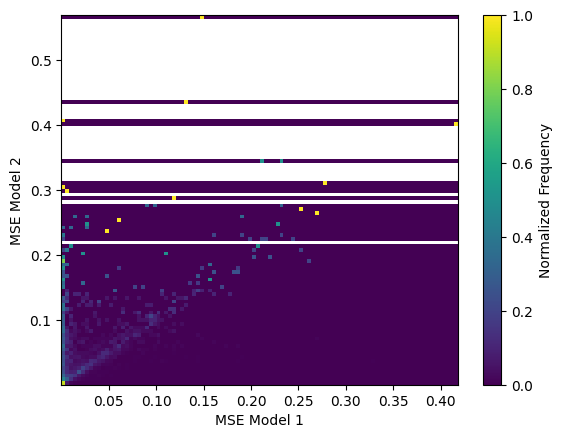

In [45]:
# Normalize each column by dividing by column sums
hist, xedges, yedges = np.histogram2d(mse, mse2, bins=100)
hist = hist / hist.sum(axis=0, keepdims=True)  # Normalize columns

plt.pcolormesh(xedges, yedges, hist.T)  # Transpose to match hist2d orientation
plt.colorbar(label='Normalized Frequency')
plt.xlabel('MSE Model 1')
plt.ylabel('MSE Model 2') 
plt.show()

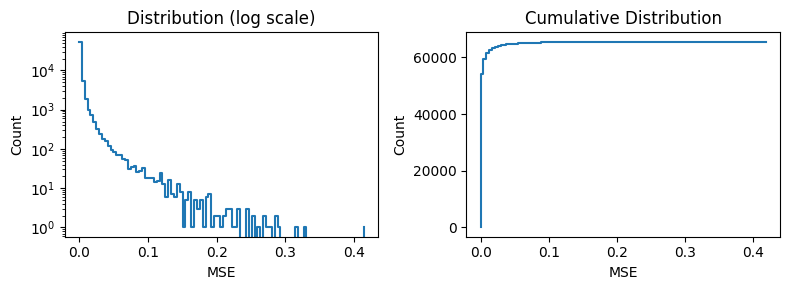

In [37]:
loss = torch.nn.MSELoss(reduction='none')
mse = loss(values_true, values_pred).mean(dim=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Regular histogram
vals, bin_edges = np.histogram(mse, bins=100)
ax1.step(bin_edges[:-1], vals, where='post')
ax1.set_yscale('log')
ax1.set_title('Distribution (log scale)')
ax1.set_xlabel('MSE')
ax1.set_ylabel('Count')

# Cumulative histogram
vals, bin_edges = np.histogram(mse, bins=100)
vals = np.insert(vals, 0, 0)
ax2.step(bin_edges, np.cumsum(vals))
ax2.set_title('Cumulative Distribution')
ax2.set_xlabel('MSE')
ax2.set_ylabel('Count')


plt.tight_layout()
plt.show()
